## DataFrame benchmarks with object vs. string[pyarrow] data

In [1]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.24.2",
  "pandas": "2.0.0rc1",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [2]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
from dask.distributed import PipInstall, PackageInstall
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt


In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster

LocalCluster(bbef928d, 'tcp://127.0.0.1:63769', workers=4, threads=12, memory=64.00 GiB)

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63769,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:63782,Total threads: 3
Dashboard: http://127.0.0.1:63788/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:63772,


In [5]:
file_paths = [
    f"s3://nyc-tlc/trip data/yellow_tripdata_{year}*.parquet"
    for year in (2021, 2022)
]
file_paths

['s3://nyc-tlc/trip data/yellow_tripdata_2021*.parquet',
 's3://nyc-tlc/trip data/yellow_tripdata_2022*.parquet']

In [6]:
ddf = dd.read_parquet(
    file_paths,
    columns=["VendorID", "passenger_count", "trip_distance", "store_and_fwd_flag", "total_amount"],
)

In [7]:
wait(ddf);

In [ ]:
ddf.head(3)

In [8]:
ddf

,VendorID,passenger_count,trip_distance,store_and_fwd_flag,total_amount
npartitions=24,,,,,
,int64,float64,float64,object,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [9]:
ddf.dtypes

VendorID                int64
passenger_count       float64
trip_distance         float64
store_and_fwd_flag     object
total_amount          float64
dtype: object

In [ ]:
ddf.size.compute()

In [10]:
ddf = ddf.repartition(partition_size="100Mb").persist()

In [11]:
ddf.npartitions

76

In [ ]:
ddf.memory_usage_per_partition().compute()

In [22]:
with dask.config.set({"dataframe.convert_string": True}):
    ddf2 = dd.read_parquet(
        file_paths,
        columns=["VendorID", "passenger_count", "trip_distance", "store_and_fwd_flag", "total_amount"],
        split_row_groups=True,
    )

In [27]:
wait(ddf2);

In [24]:
ddf2 = ddf2.repartition(partition_size="100Mb").persist()

In [25]:
ddf2.npartitions

42

In [ ]:
ddf2.memory_usage_per_partition().compute()

In [26]:
ddf2.dtypes

VendorID                        int64
passenger_count               float64
trip_distance                 float64
store_and_fwd_flag    string[pyarrow]
total_amount                  float64
dtype: object

In [12]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()
ms5 = MemorySampler()
ms6 = MemorySampler()

In [14]:
# 1
with ms1.sample("object string", interval=0.01):
    %timeit -r 5 -n 2 ddf.store_and_fwd_flag.unique().compute()

308 ms ± 93.5 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [30]:
# 1, ddf2
with ms1.sample("arrow string", interval=0.01):
    %timeit -r 5 -n 2 ddf2.store_and_fwd_flag.unique().compute()

The slowest run took 12.85 times longer than the fastest. This could mean that an intermediate result is being cached.
36.6 ms ± 25.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Unique'}, xlabel='time', ylabel='Cluster memory (GiB)'>

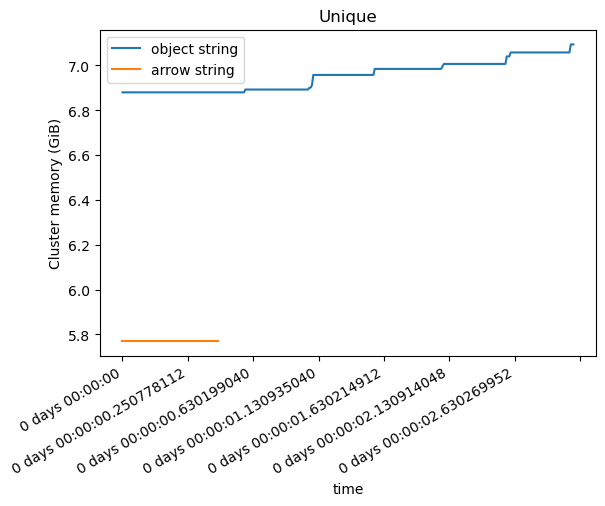

In [31]:
ms1.plot(align=True, title="Unique")

In [16]:
# 2
with ms2.sample("object string", interval=0.1):
    %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").total_amount.sum().compute()

The slowest run took 96.28 times longer than the fastest. This could mean that an intermediate result is being cached.
342 ms ± 298 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [32]:
# 2, ddf2
with ms2.sample("arrow string"):
    %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").total_amount.sum().compute()

239 ms ± 4.35 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/sum'}, xlabel='time', ylabel='Cluster memory (GiB)'>

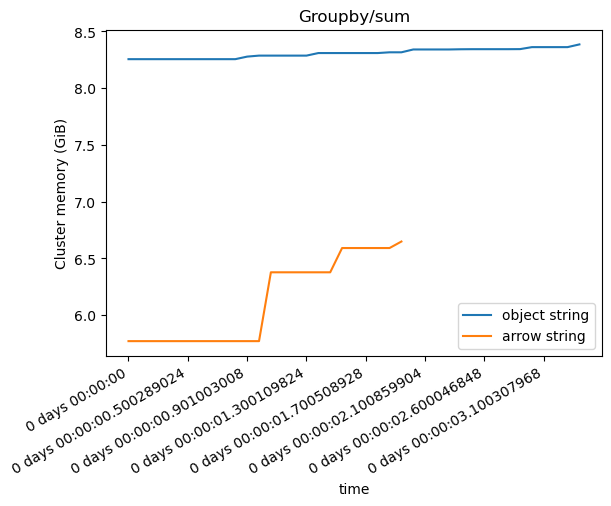

In [33]:
ms2.plot(align=True, title="Groupby/sum")

In [17]:
# 3
with ms3.sample("object string", interval=0.05):
    %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").trip_distance.mean().compute()

843 ms ± 294 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [34]:
# 3, ddf2
with ms3.sample("arrow string", interval=0.05):
    %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").trip_distance.mean().compute()

423 ms ± 9.31 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/mean'}, xlabel='time', ylabel='Cluster memory (GiB)'>

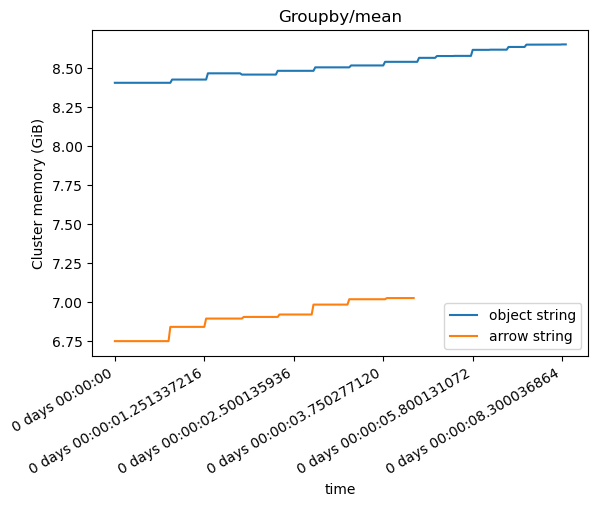

In [35]:
ms3.plot(align=True, title="Groupby/mean")

In [ ]:
# 4
#with ms4.sample("object string"):
#    %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").trip_distance.median().compute()

In [ ]:
#4, ddf2
#with ms4.sample("arrow string"):
#    %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").trip_distance.median().compute()

In [ ]:
# ms4.plot(align=True, title="Groupby/median")

In [18]:
# 5
with ms5.sample("object string", interval=0.1):
    %timeit -r 5 -n 2 ddf.store_and_fwd_flag.str.len().compute()

2.68 s ± 60.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [36]:
# 5, ddf2
with ms5.sample("arrow string", interval=0.1):
    %timeit -r 5 -n 2 ddf2.store_and_fwd_flag.str.len().compute()

586 ms ± 17.7 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

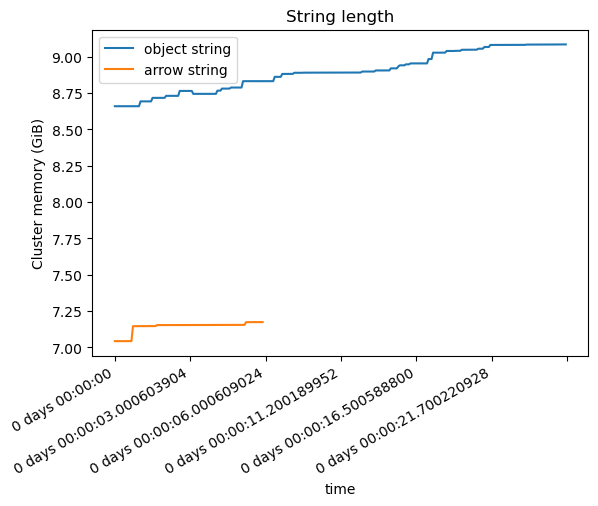

In [37]:
ms5.plot(align=True, title="String length")

In [19]:
# 6
with ms6.sample("object string", interval=0.1):
    %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").passenger_count.sum().compute()

The slowest run took 104.30 times longer than the fastest. This could mean that an intermediate result is being cached.
278 ms ± 252 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [38]:
#6, ddf2
with ms6.sample("arrow string", interval=0.1):
    %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").passenger_count.sum().compute()

235 ms ± 6.85 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/sum 2'}, xlabel='time', ylabel='Cluster memory (GiB)'>

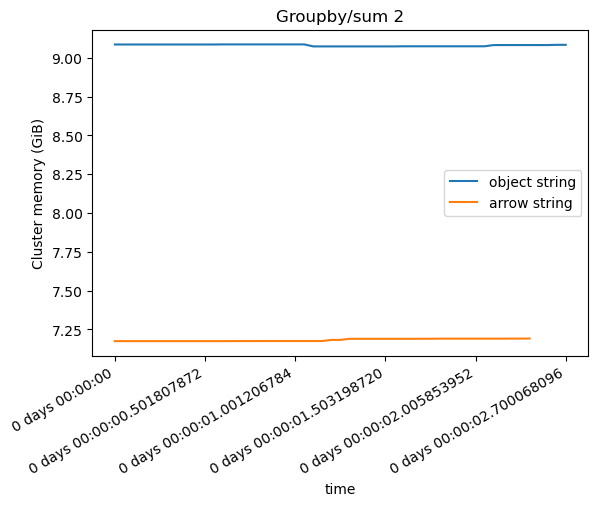

In [39]:
ms6.plot(align=True, title="Groupby/sum 2")

In [40]:
client.restart()  # Release futures and clear up memory on the cluster

2023-03-28 18:39:02,994 - distributed.nanny - WARNING - Restarting worker
2023-03-28 18:39:03,014 - distributed.nanny - WARNING - Restarting worker
2023-03-28 18:39:03,016 - distributed.nanny - WARNING - Restarting worker
2023-03-28 18:39:03,023 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63769,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: 6 minutes ago,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:64054,Total threads: 3
Dashboard: http://127.0.0.1:64057/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:63772,


In [41]:
client.close()

In [42]:
cluster.close()